In [13]:
import pandas as pd
df = pd.read_csv("cloud_usage_full_synthetic.csv")

print(df.head())


         date provider resource_id resource_type service     region  vcpu  \
0  2025-04-03      aws     aws-001            vm     EC2  us-east-1     4   
1  2025-04-04      aws     aws-001            vm     EC2  us-east-1     4   
2  2025-04-05      aws     aws-001            vm     EC2  us-east-1     4   
3  2025-04-06      aws     aws-001            vm     EC2  us-east-1     4   
4  2025-04-07      aws     aws-001            vm     EC2  us-east-1     4   

   memory_gb  cpu_util_percent  cpu_hours  memory_gb_hours  storage_gb  \
0          8            32.145      7.715            2.737     501.447   
1          8            39.469      9.473            3.405     498.943   
2          8            20.878      5.011            1.005     503.169   
3          8            22.440      5.386            1.512     501.593   
4          8            38.900      9.336            3.194     497.771   

   network_gb  is_spot  idle_flag  cost_usd  
0      10.399    False      False    2.2429  


In [14]:
print(df.describe())

              vcpu    memory_gb  cpu_util_percent    cpu_hours  \
count  9000.000000  9000.000000        9000.00000  9000.000000   
mean      3.760000    11.600000          30.40663     7.297589   
std       2.867632     9.347176          17.34796     4.163507   
min       1.000000     2.000000           6.58000     1.579000   
25%       1.000000     4.000000          17.28575     4.148750   
50%       3.000000     8.000000          23.75750     5.702000   
75%       8.000000    16.000000          39.28850     9.429500   
max       8.000000    32.000000          83.27200    19.985000   

       memory_gb_hours  storage_gb   network_gb     cost_usd  
count      9000.000000  9000.00000  9000.000000  9000.000000  
mean          2.797637   203.24169    10.751765     2.208572  
std           3.194742   162.06859     3.067459     1.889808  
min           0.070000     2.67700     0.000000     0.306600  
25%           0.890000    60.54375     8.712500     0.774500  
50%           1.637500   14

In [15]:
# Total cost by provider
print(df.groupby("provider")["cost_usd"].sum())

provider
aws       7337.7428
azure    12539.4013
Name: cost_usd, dtype: float64


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load dataset
df = pd.read_csv("cloud_usage_full_synthetic.csv")
df['date'] = pd.to_datetime(df['date'])

# Example: forecast storage for resource aws-001
res_df = df[df['resource_id']=="aws-001"][['date','storage_gb']].set_index('date')
y = res_df['storage_gb']

In [12]:
%pip install prophet
%pip install statsmodels
%pip install tensorflow

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ----- ---------------------------------- 1.8/13.3 MB 9.1 MB/s eta 0:00:02
   ----------- ---------------------------- 3.9/13.3 MB 9.4 MB/s eta 0:00:01
   ---------------- ----------------------- 5.5/13.3 MB 8.8 MB/s eta 0:00:01
   ------------------ --------------------- 6.3/13.3 MB 8.0 MB/s eta 0:00:01
   --------------------- ------------------ 7.1/13.3 MB 6.7 MB/s eta 0:00:01
   ----------------------- ---------------- 7.9/13.3 MB 6.2 MB/s eta 0:00:01
   -------------------------- ------------- 8.9/13.3 MB 6.0 MB/s eta 0:00:01
   ------------------------------ --------- 10.2/13.3 MB 6.1 MB/s eta 0:00:01
   ---------------------------------- ----- 11.5/13.3 MB 6.0 MB/s eta 0:00:01
   ------------------------------------ --- 12.3/13.3 MB 5.9 MB/s eta 0:00:01
   -------------------------------------- - 12.8/13.3 MB 5.7 MB/s eta 0:00:01
   ---------------------------------------- 13.3/13.3 MB 5.3 MB/s  0:00:02
   -

18:31:48 - cmdstanpy - INFO - Chain [1] start processing
18:31:49 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x500 with 0 Axes>

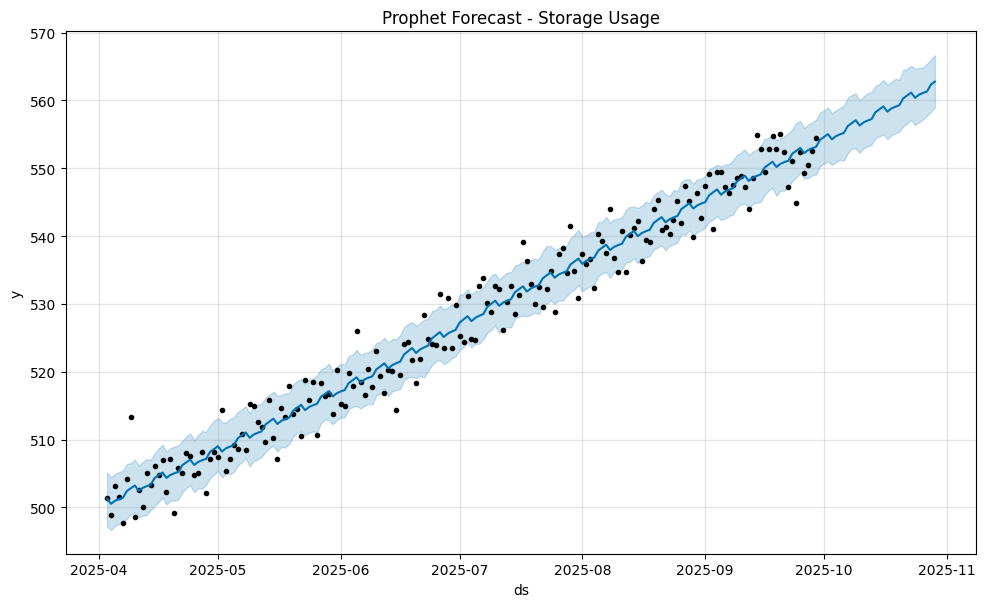

In [17]:
# ----------------------------
# 1. PROPHET MODEL
# ----------------------------
prophet_df = res_df.reset_index()[["date", "storage_gb"]]
prophet_df.columns = ["ds", "y"]

prophet_model = Prophet()
prophet_model.fit(prophet_df)

future = prophet_model.make_future_dataframe(periods=30)
forecast_prophet = prophet_model.predict(future)

plt.figure(figsize=(10,5))
prophet_model.plot(forecast_prophet)
plt.title("Prophet Forecast - Storage Usage")
plt.show()

c:\Users\jayan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\jayan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\jayan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


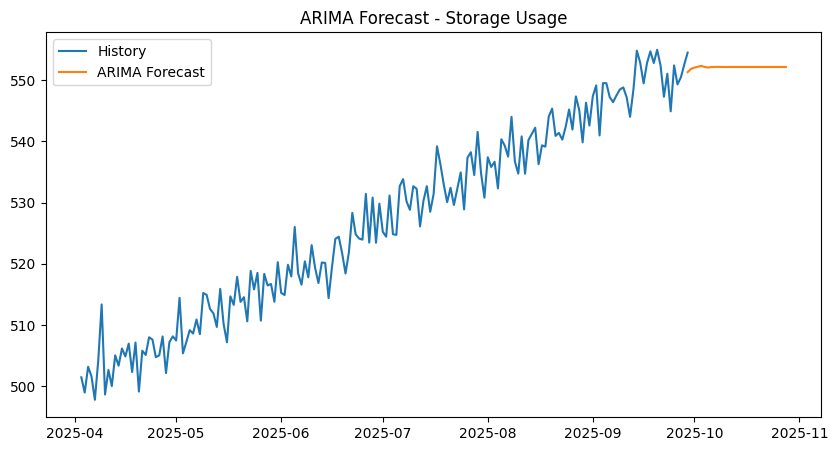

In [18]:
# ----------------------------
# 2. ARIMA MODEL
# ----------------------------
# Fit ARIMA (p,d,q = 5,1,0 as example)
arima_model = ARIMA(y, order=(5,1,0))
arima_fit = arima_model.fit()

forecast_arima = arima_fit.forecast(steps=30)

plt.figure(figsize=(10,5))
plt.plot(y.index, y, label="History")
plt.plot(pd.date_range(y.index[-1], periods=30, freq="D"), forecast_arima, label="ARIMA Forecast")
plt.legend()
plt.title("ARIMA Forecast - Storage Usage")
plt.show()


c:\Users\jayan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2490
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1805 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1074 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0415 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0120 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0084 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 
Epoch 13/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036 
Epoch 14/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 
Epoch 15/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 
Epoch 16/20
9/9 ━━━━━━━━━━━━━━━━━━━

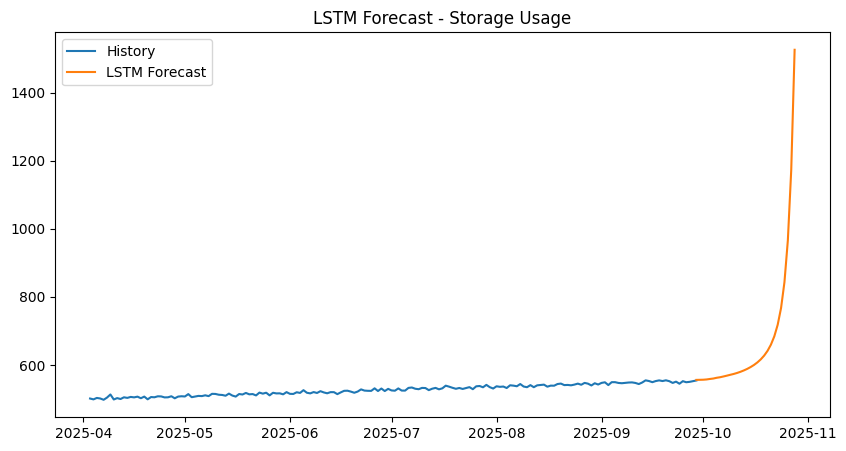

In [19]:
# ----------------------------
# 3. LSTM MODEL
# ----------------------------
# Prepare data
scaler = MinMaxScaler(feature_range=(0,1))
y_scaled = scaler.fit_transform(y.values.reshape(-1,1))

# Create sequences
def create_sequences(data, seq_length=10):
    X, Y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        Y.append(data[i+seq_length])
    return np.array(X), np.array(Y)

seq_length = 10
X, Y = create_sequences(y_scaled, seq_length)

# Split into train/test
split = int(len(X)*0.8)
X_train, Y_train = X[:split], Y[:split]
X_test, Y_test = X[split:], Y[split:]

# Build LSTM
lstm_model = Sequential([
    LSTM(50, activation="relu", input_shape=(seq_length,1)),
    Dense(1)
])
lstm_model.compile(optimizer="adam", loss="mse")
lstm_model.fit(X_train, Y_train, epochs=20, batch_size=16, verbose=1)

# Forecast next 30 steps
last_seq = X_test[-1]
preds = []
current_seq = last_seq

for _ in range(30):
    pred = lstm_model.predict(current_seq.reshape(1,seq_length,1), verbose=0)
    preds.append(pred[0,0])
    current_seq = np.append(current_seq[1:], pred).reshape(seq_length,1)

forecast_lstm = scaler.inverse_transform(np.array(preds).reshape(-1,1))

# Plot
plt.figure(figsize=(10,5))
plt.plot(y.index, y.values, label="History")
plt.plot(pd.date_range(y.index[-1], periods=30, freq="D"), forecast_lstm, label="LSTM Forecast")
plt.legend()
plt.title("LSTM Forecast - Storage Usage")
plt.show()

In [21]:
# Use last 30 days as test
train = y[:-30]
test = y[-30:]

In [22]:
prophet_df = train.reset_index()[['date','storage_gb']]
prophet_df.columns = ['ds','y']
prophet_model = Prophet()
prophet_model.fit(prophet_df)

future = prophet_model.make_future_dataframe(periods=30)
forecast_prophet = prophet_model.predict(future)
y_pred_prophet = forecast_prophet['yhat'][-30:].values


18:34:40 - cmdstanpy - INFO - Chain [1] start processing
18:34:40 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
arima_model = ARIMA(train, order=(5,1,0))  # p,d,q can be tuned
arima_fit = arima_model.fit()
y_pred_arima = arima_fit.forecast(steps=30).values


c:\Users\jayan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\jayan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\jayan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [24]:
# Scale data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1,1))

# Prepare sequences
def create_seq(data, seq_len=10):
    X, Y = [], []
    for i in range(len(data)-seq_len):
        X.append(data[i:i+seq_len])
        Y.append(data[i+seq_len])
    return np.array(X), np.array(Y)

seq_len = 10
X_train, Y_train = create_seq(train_scaled, seq_len)

# LSTM expects 3D input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_len,1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, Y_train, epochs=20, batch_size=16, verbose=0)

# Forecast next 30 steps
last_seq = train_scaled[-seq_len:]
preds_scaled = []
current_seq = last_seq.copy()
for _ in range(30):
    pred = lstm_model.predict(current_seq.reshape(1,seq_len,1), verbose=0)
    preds_scaled.append(pred[0,0])
    current_seq = np.append(current_seq[1:], pred[0,0])

y_pred_lstm = scaler.inverse_transform(np.array(preds_scaled).reshape(-1,1)).flatten()


c:\Users\jayan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
def calc_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred)/y_true))*100
    return mae, rmse, mape

metrics = {}
metrics['Prophet'] = calc_metrics(test.values, y_pred_prophet)
metrics['ARIMA'] = calc_metrics(test.values, y_pred_arima)
metrics['LSTM'] = calc_metrics(test.values, y_pred_lstm)

for model, m in metrics.items():
    print(f"{model} -> MAE: {m[0]:.3f}, RMSE: {m[1]:.3f}, MAPE: {m[2]:.2f}%")


Prophet -> MAE: 2.549, RMSE: 3.218, MAPE: 0.46%
ARIMA -> MAE: 5.636, RMSE: 6.389, MAPE: 1.02%
LSTM -> MAE: 8.275, RMSE: 11.438, MAPE: 1.50%


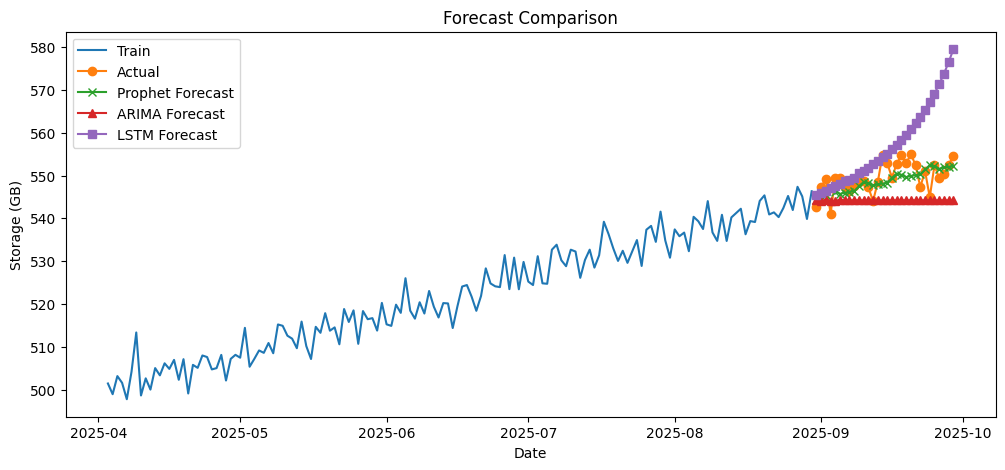

In [27]:
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual', marker='o')
plt.plot(test.index, y_pred_prophet, label='Prophet Forecast', marker='x')
plt.plot(test.index, y_pred_arima, label='ARIMA Forecast', marker='^')
plt.plot(test.index, y_pred_lstm, label='LSTM Forecast', marker='s')
plt.title("Forecast Comparison")
plt.xlabel("Date")
plt.ylabel("Storage (GB)")
plt.legend()
plt.show()
